# Lego Reinforcement Learning

In [1]:
from LegoRL import *

In [2]:
import gym
env = gym.make('CartPole-v0').unwrapped    # unwrapped required to remove TimeLimit wrapper

In [3]:
import torch
import torch.nn as nn

CartpoleNN = lambda input_size, output_size: nn.Sequential(
                nn.Linear(input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, output_size)
)

## Basic principles:

* **RLmodule** is a base class for all building blocks of algorithms.
* **System** stores logs, information about environment, controls saving-loading, etc.

In [4]:
# create system with our environment
# this is required to connect all modules together.
system = System(env)

In [5]:
system.mdp

Gamma: 0.99
Observation space: (4,)
Action space: discrete, 2 actions
Rewards space: ()

In [6]:
# create building block
runner = Runner(system)

In [7]:
# create another one
policy = RandomPolicy(system)

In [8]:
# here is the list of hyperparameters
system.hyperparameters()

{'Runner': {'num_envs': 1}, 'gamma': 0.99}

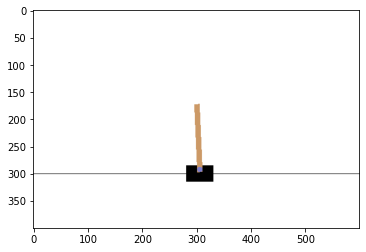

C:\Users\Scrat\anaconda3\lib\site-packages\torch\tensor.py:605: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:840.)
  return super(Tensor, self).refine_names(names)


In [9]:
# Runner block also has special method to play one game in the environment and record everything
rollout = runner.play(policy, render=True)

We received **Storage**: dictionary of several tensors. Very convinient structure for RL ;)

In [10]:
rollout

{'states': State Representation (13, 1, 4),
 'is_start': Flag Representation (13, 1),
 'actions': Action Representation (13, 1),
 'rewards': Reward Representation (13, 1),
 'next_states': State Representation (13, 1, 4),
 'discounts': Discount Representation (13, 1)}

# Visualization

Each step our pipeline will cal _iteration_ method from all our modules and at the end of iteration --- _visualise_ method for additional logging and plotting. Adding ***Visualizer*** in our system will draw plots each *timer* step.

In [20]:
# Let's create our own algorithm! 
class MyAgent(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner = Runner(self)
        self.policy = RandomPolicy(self)
    
    # this method will be called on each iteration
    def iteration(self):
        # policies might return more that just actions
        # so storage here is a dictionary with "actions" key
        storage = self.policy(self.runner.states)
        self.runner.step(**storage)

In [21]:
agent = MyAgent(env)
visualizer = Visualizer(agent, timer=100)

In [22]:
# modules inside algorithm
agent

<Runner>: Makes steps in 1 parallel environments
<RandomPolicy>: Acts randomly
<Visualizer>: Plots logs every 100 iteration

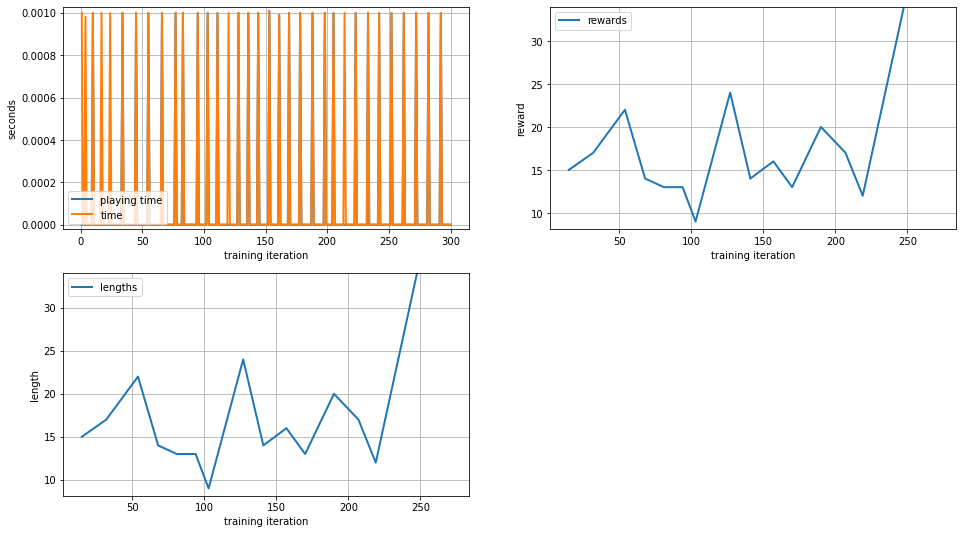

In [23]:
# run 300 iterations
agent.run(300)

System also stores all logs from session.

In [24]:
agent.logger.keys()

dict_keys(['playing time', 'time', 'visualization time', 'rewards', 'lengths', 'episode ends'])

In [25]:
agent.logger['rewards']

[15.0,
 17.0,
 22.0,
 14.0,
 13.0,
 13.0,
 9.0,
 24.0,
 14.0,
 16.0,
 13.0,
 20.0,
 17.0,
 12.0,
 52.0]

Also it measures time:

In [26]:
agent.wallclock()   # iterations time

0.03396129608154297

In [27]:
agent.viz_wallclock() # visualize time

1.1747312545776367

# DQN

Let's look at DQN implementation.

In [11]:
class DQN(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Performs steps in env and logs rewards
        self.runner = Runner(self)
        
        # With eps probability substitues actions with random ones
        self.egreedy = eGreedy(self)        
        
        # Neural Network wrapper that takes states as input and outputs Q        
        self.q_network = QNetwork(self, CartpoleNN)
        
        # Copy of self.q_network that will update every <timer> iterations
        self.target_network = Frozen(self, self.q_network)
        
        # Stores data in numpy format
        self.replay  = ReplayBuffer(self)
        
        # Can sample from replay from uniform distribution
        self.sampler = Sampler(self, self.replay)
        
        # Computes one-step approximation
        self.target  = OneStep(self)
        
        # Computes loss by comparing two values
        # It can handle more complicated representations like Categorical Q
        self.loss    = CriticLoss(self)
        
        
        # Standard SGD trainer
        self.trainer = Trainer(self, models=self.q_network)
    
    def iteration(self):
        # Data collection---------------------------------------------------------------
        with torch.no_grad():
            actions = self.q_network(self.runner.states).greedy()
            actions = self.egreedy(actions)

            transition = self.runner.step(actions)
            self.replay.store(transition)
        
        # Training ---------------------------------------------------------------------
        batch = self.sampler.sample()
        if batch:
            prediction = self.q_network.Q(batch.states, batch.actions)
            target = self.target(self.target_network, **batch)
            loss = self.loss(prediction, target)
            self.trainer.optimize(loss)
        
        # Target network update --------------------------------------------------------
        self.target_network.update()

In [12]:
dqn = DQN(env)
visualizer = Visualizer(dqn)

Initializing <QNetwork>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([2])


In [13]:
dqn

<Runner>: Makes steps in 1 parallel environments
<eGreedy>: Mixes actions with random actions
<QNetwork>: Models Q-function
<FrozenModule>: Frozen copy of <QNetwork>
<ReplayBuffer>: Stores data in raw numpy format
<Sampler>: Samples mini-batches uniformly
<CriticLoss>: Calculates TD loss
<OneStep>: Returns one-step approximation
<Trainer>: Standard SGD loss optimization
<Visualizer>: Plots logs every 1000 iteration

In [14]:
dqn.hyperparameters()

{'Runner': {'num_envs': 1},
 'eGreedy': {'epsilon_start': 1, 'epsilon_final': 0.01, 'epsilon_decay': 500},
 'FrozenModule': {'timer': 100},
 'ReplayBuffer': {'capacity': 10000},
 'Sampler': {'batch_size': 32, 'cold_start': 100},
 'CriticLoss': {'weight': 1},
 'Trainer': {'clip_gradients': None, 'optimizer': 'Adam'},
 'gamma': 0.99}

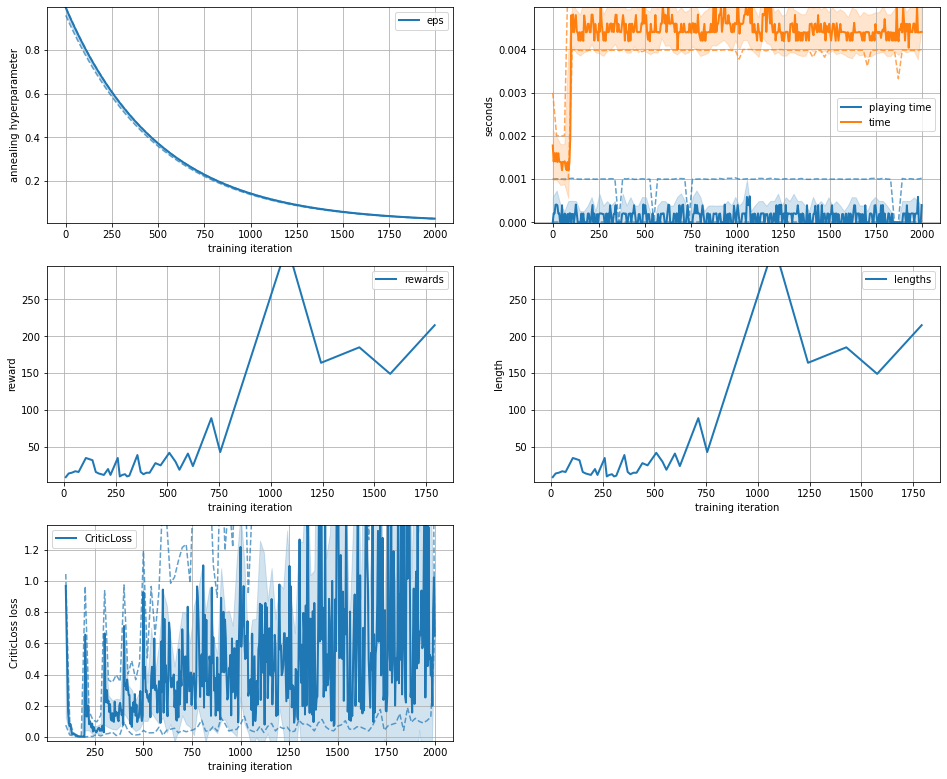

In [15]:
# run 2000 iterations
dqn.run(2000)

# Twin DQN

Let's write Twin DQN implementation: train two Q-functions using single runner and replay buffer and use Double estimation for target.

In [9]:
class DQN(RLmodule):
    def __init__(self, parent):
        super().__init__(parent)
        
        self.q_network = QNetwork(self, CartpoleNN)
        self.double    = Double(self)
        self.loss      = CriticLoss(self)
        self.trainer   = Trainer(self, models=self.q_network)
    
    def optimize(self, batch, evaluator):
        if batch:
            prediction = self.q_network.Q(batch.states, batch.actions)
            target = self.double(evaluator, self.q_network, **batch)
            loss = self.loss(prediction, target)
            self.trainer.optimize(loss)

In [14]:
class TwinDQN(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner  = Runner(self)
        self.egreedy = eGreedy(self)  
        self.replay  = ReplayBuffer(self)
        self.sampler = Sampler(self, self.replay)
        
        self.dqn1 = DQN(self)
        self.dqn2 = DQN(self)
    
    def iteration(self):
        # Data collection -------------------------------------------------------------
        with torch.no_grad():
            actions = self.dqn1.q_network(self.runner.states).greedy()
            actions = self.egreedy(actions)

            transition = self.runner.step(actions)
            self.replay.store(transition)
        
        # Training --------------------------------------------------------------------
        batch = self.sampler.sample()
        self.dqn1.optimize(batch, self.dqn2.q_network)
        batch = self.sampler.sample()
        self.dqn2.optimize(batch, self.dqn1.q_network)

In [15]:
twindqn = TwinDQN(env)
visualizer = Visualizer(twindqn)

Initializing <QNetwork>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([2])
Initializing <QNetwork>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([2])


What happened here? Let's look!

In [16]:
twindqn

<Runner>: Makes steps in 1 parallel environments
<eGreedy>: Mixes actions with random actions
<ReplayBuffer>: Stores data in raw numpy format
<Sampler>: Samples mini-batches uniformly
<DQN>:
    <DQN.QNetwork>: Models Q-function
    <DQN.Double>: Decouples action selection and action evaluation
    <DQN.CriticLoss>: Calculates TD loss
    <DQN.Trainer>: Standard SGD loss optimization
    
<DQN2>:
    <DQN2.QNetwork>: Models Q-function
    <DQN2.Double>: Decouples action selection and action evaluation
    <DQN2.CriticLoss>: Calculates TD loss
    <DQN2.Trainer>: Standard SGD loss optimization
    
<Visualizer>: Plots logs every 1000 iteration

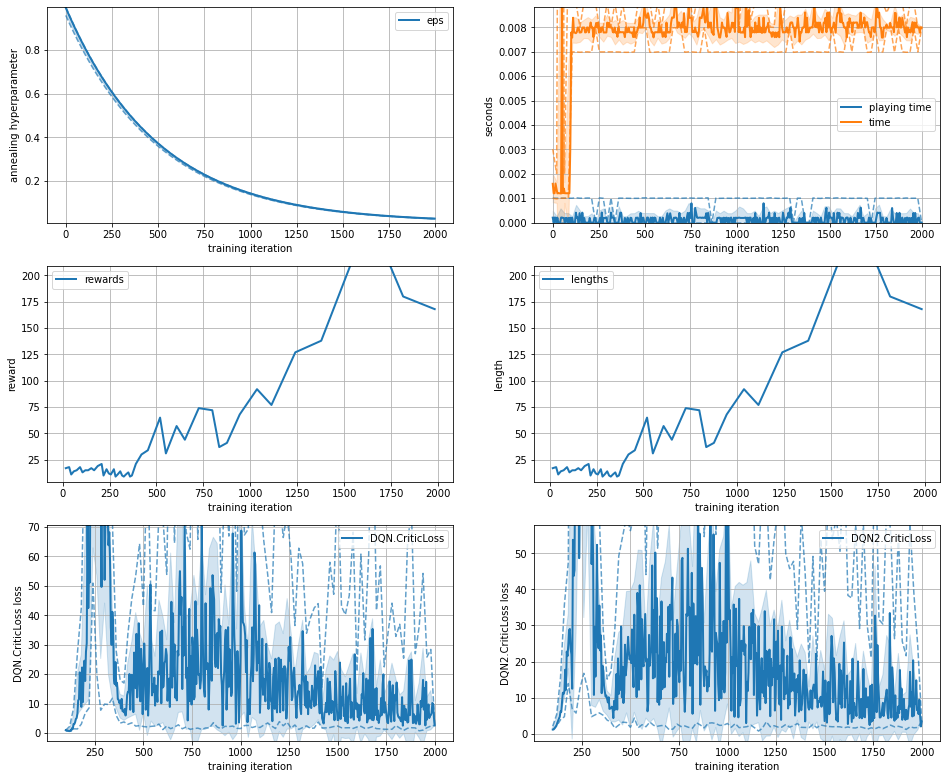

In [17]:
# train for 2000 iterations
twindqn.run(2000)

# Pipeline

It is better to define env as function, returning function, to be able to run OpenAI VecEnvs.

In [1]:
from LegoRL import *

In [2]:
import gym
def make_env():
    def _thunk():
        return gym.make('CartPole-v0').unwrapped
    return _thunk

After checking the environment, define PyTorch network.

In [3]:
import torch
import torch.nn as nn

CartpoleNN = lambda input_size, output_size: nn.Sequential(
                nn.Linear(input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),    
                nn.Linear(128, output_size),
)

In [12]:
class DoubleDQN(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner = Runner(self)
        self.egreedy = eGreedy(self)        
        
        self.q_network      = QNetwork(self, CartpoleNN)
        self.target_network = Frozen(self, self.q_network)
        
        self.replay  = ReplayBuffer(self)
        self.sampler = Sampler(self, self.replay)
        self.double  = Double(self)
        self.loss    = CriticLoss(self)
        self.trainer = Trainer(self, models=self.q_network)
    
    def iteration(self):
        # Data collection---------------------------------------------------------------
        with torch.no_grad():
            actions = self.q_network(self.runner.states).greedy()
            actions = self.egreedy(actions)

            transition = self.runner.step(actions)
            self.replay.store(transition)
        
        # Training ---------------------------------------------------------------------
        batch = self.sampler.sample()
        if batch:
            prediction = self.q_network.Q(batch.states, batch.actions)
            target = self.double(self.target_network, self.q_network, **batch)
            loss = self.loss(prediction, target)
            self.trainer.optimize(loss)
        
        # Target network update --------------------------------------------------------
        self.target_network.update()

Define **System**'s parameters to automatically save model each *save_timer*-s iteration.

In [13]:
dqn = DoubleDQN(make_env=make_env, save_timer=500, folder_name="models/cartpole_dqn")

Initializing <QNetwork>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([2])


Add visualizer and **Player** to evaluate some policy each *timer*-s iteration.

In [14]:
player     = Player(dqn, policy=dqn.q_network.act, timer=500, record_timer=1000)
visualizer = Visualizer(dqn)

Run ;)

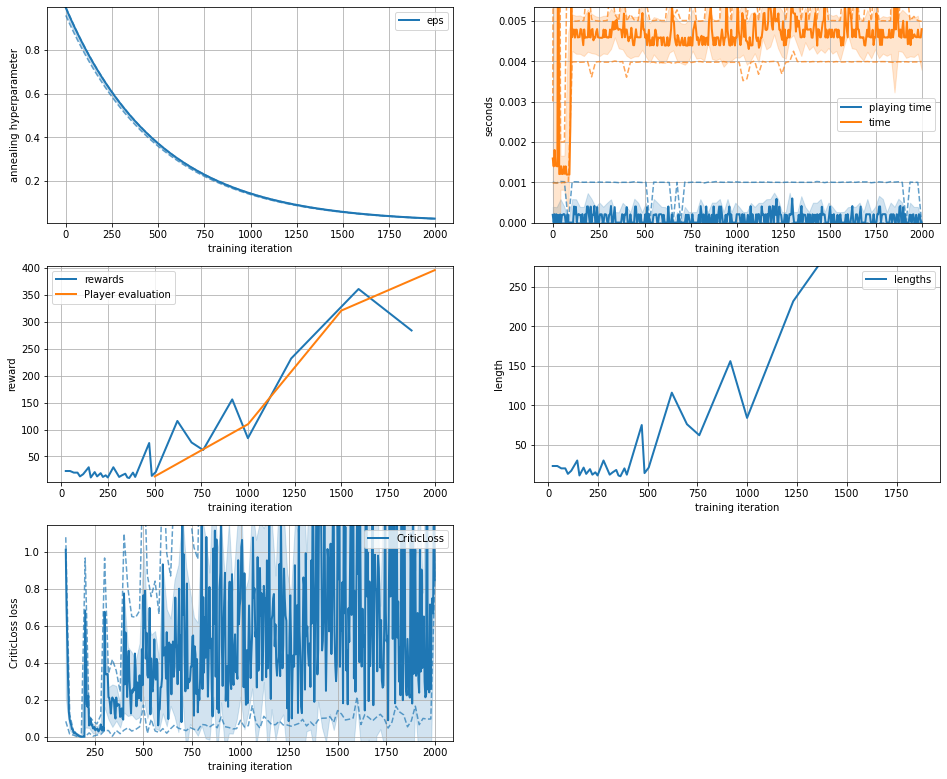

In [15]:
dqn.run(2000)

To continue training after reloading notebook, simply load the **System**.

In [16]:
dqn.load()

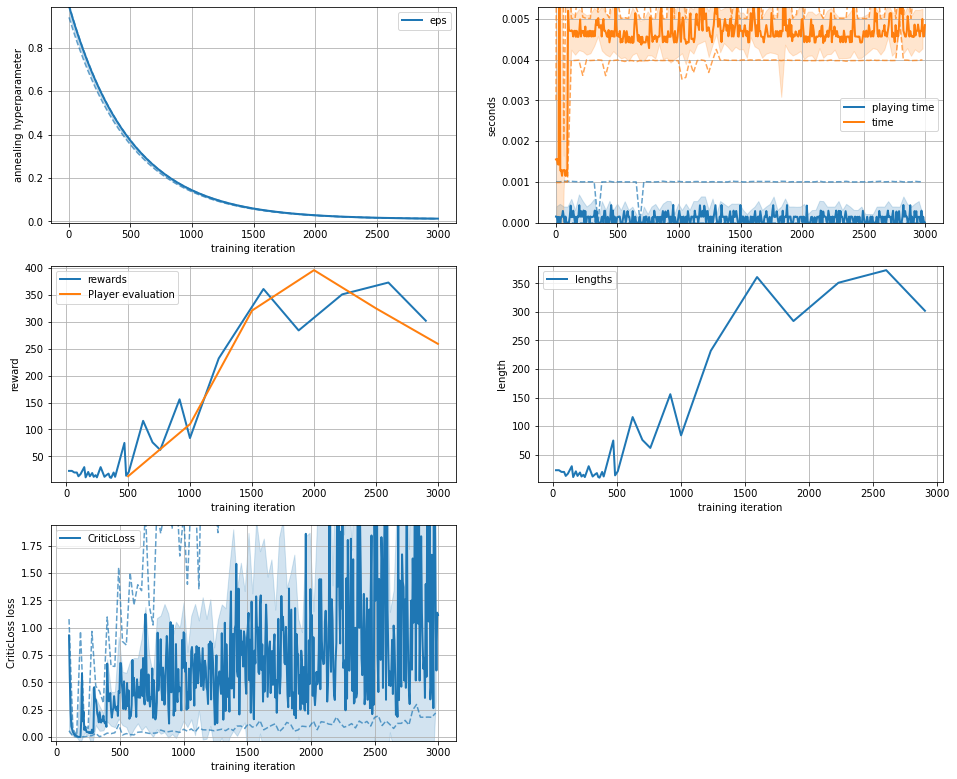

In [17]:
dqn.run(1000)

As reloading can cause some effects (e.g. loosing the replay buffer), *system.reload_messages* stores information about occured reloads:

In [18]:
dqn.reload_messages

['iteration 2000: reloaded (replay buffers are lost)']

In [19]:
# FPS (visualization and Player evaluation is not taken into account)
dqn.runner.fps

216.9208216224491

In [20]:
# total episodes played
dqn.runner.episodes_done

37

In [21]:
# play one game and sum rewards
rollout = dqn.runner.play(dqn.q_network.act, store_frames=True)
sum(rollout.rewards.numpy)

array([250.], dtype=float32)

In [22]:
rollout.keys()

dict_keys(['states', 'is_start', 'actions', 'Q', 'rewards', 'next_states', 'discounts', 'frames'])

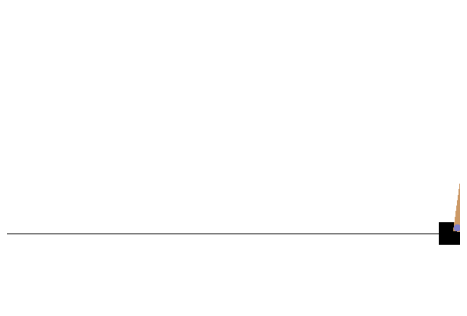

In [23]:
# displaying using HTML
show_animation(rollout.frames)